In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from ood_detection_helper import *
from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc


from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import umap
from sklearn.preprocessing import MinMaxScaler 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  0
[]


'2.2.0'

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Loading OOD datasets

In [5]:
with open("scores_full_norm_test.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.shape

TensorShape([26000, 10])

In [6]:
with open("ood_scores_full_norm.p", "rb") as f:
    ood_dict = pickle.load(f)
ood_dict.keys()

dict_keys(['LSUN', 'LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN', 'gaussian', 'uniform', 'cifar'])

## TODO: Resave them as tensors

In [7]:
inlier_scores = score_dict.numpy()
outlier_scores = [x.numpy() for x in ood_dict.values()]

In [8]:
ood_names = list(ood_dict.keys())
ood_names, len(outlier_scores)

(['LSUN',
  'LSUN_resize',
  'Imagenet',
  'Imagenet_resize',
  'iSUN',
  'gaussian',
  'uniform',
  'cifar'],
 8)

In [10]:
# tmp = outlier_scores[-2].copy()
# oulier_scores[]

## Calculating Scores

In [11]:
LABELS = np.array(["Train", "SVHN", 'LSUN','LSUN_resize',
                   'Imagenet','Imagenet_resize','iSUN',"Gaussian", "Uniform", "CIFAR"])
COLORS = sns.color_palette("bright")

In [47]:
all_samples = np.concatenate([inlier_scores, *outlier_scores[:-3], outlier_scores[-1]])

all_labels = [0] * len(inlier_scores)

for idx, ood in enumerate(outlier_scores): #Skipping gauss and uniform
    if idx in [5,6]:
        continue
    all_labels += [idx+1]*len(ood)

captions = [LABELS[x+1] for x in all_labels]

all_samples.shape, len(all_labels), len(captions)

((84925, 10), 84925, 84925)

In [48]:
%%time
import umap

umapper = umap.UMAP(n_components = 3,
                    n_neighbors=100,
                    min_dist=0)

embedding = umapper.fit_transform(all_samples)


CPU times: user 52min, sys: 11min 16s, total: 1h 3min 16s
Wall time: 4min 1s


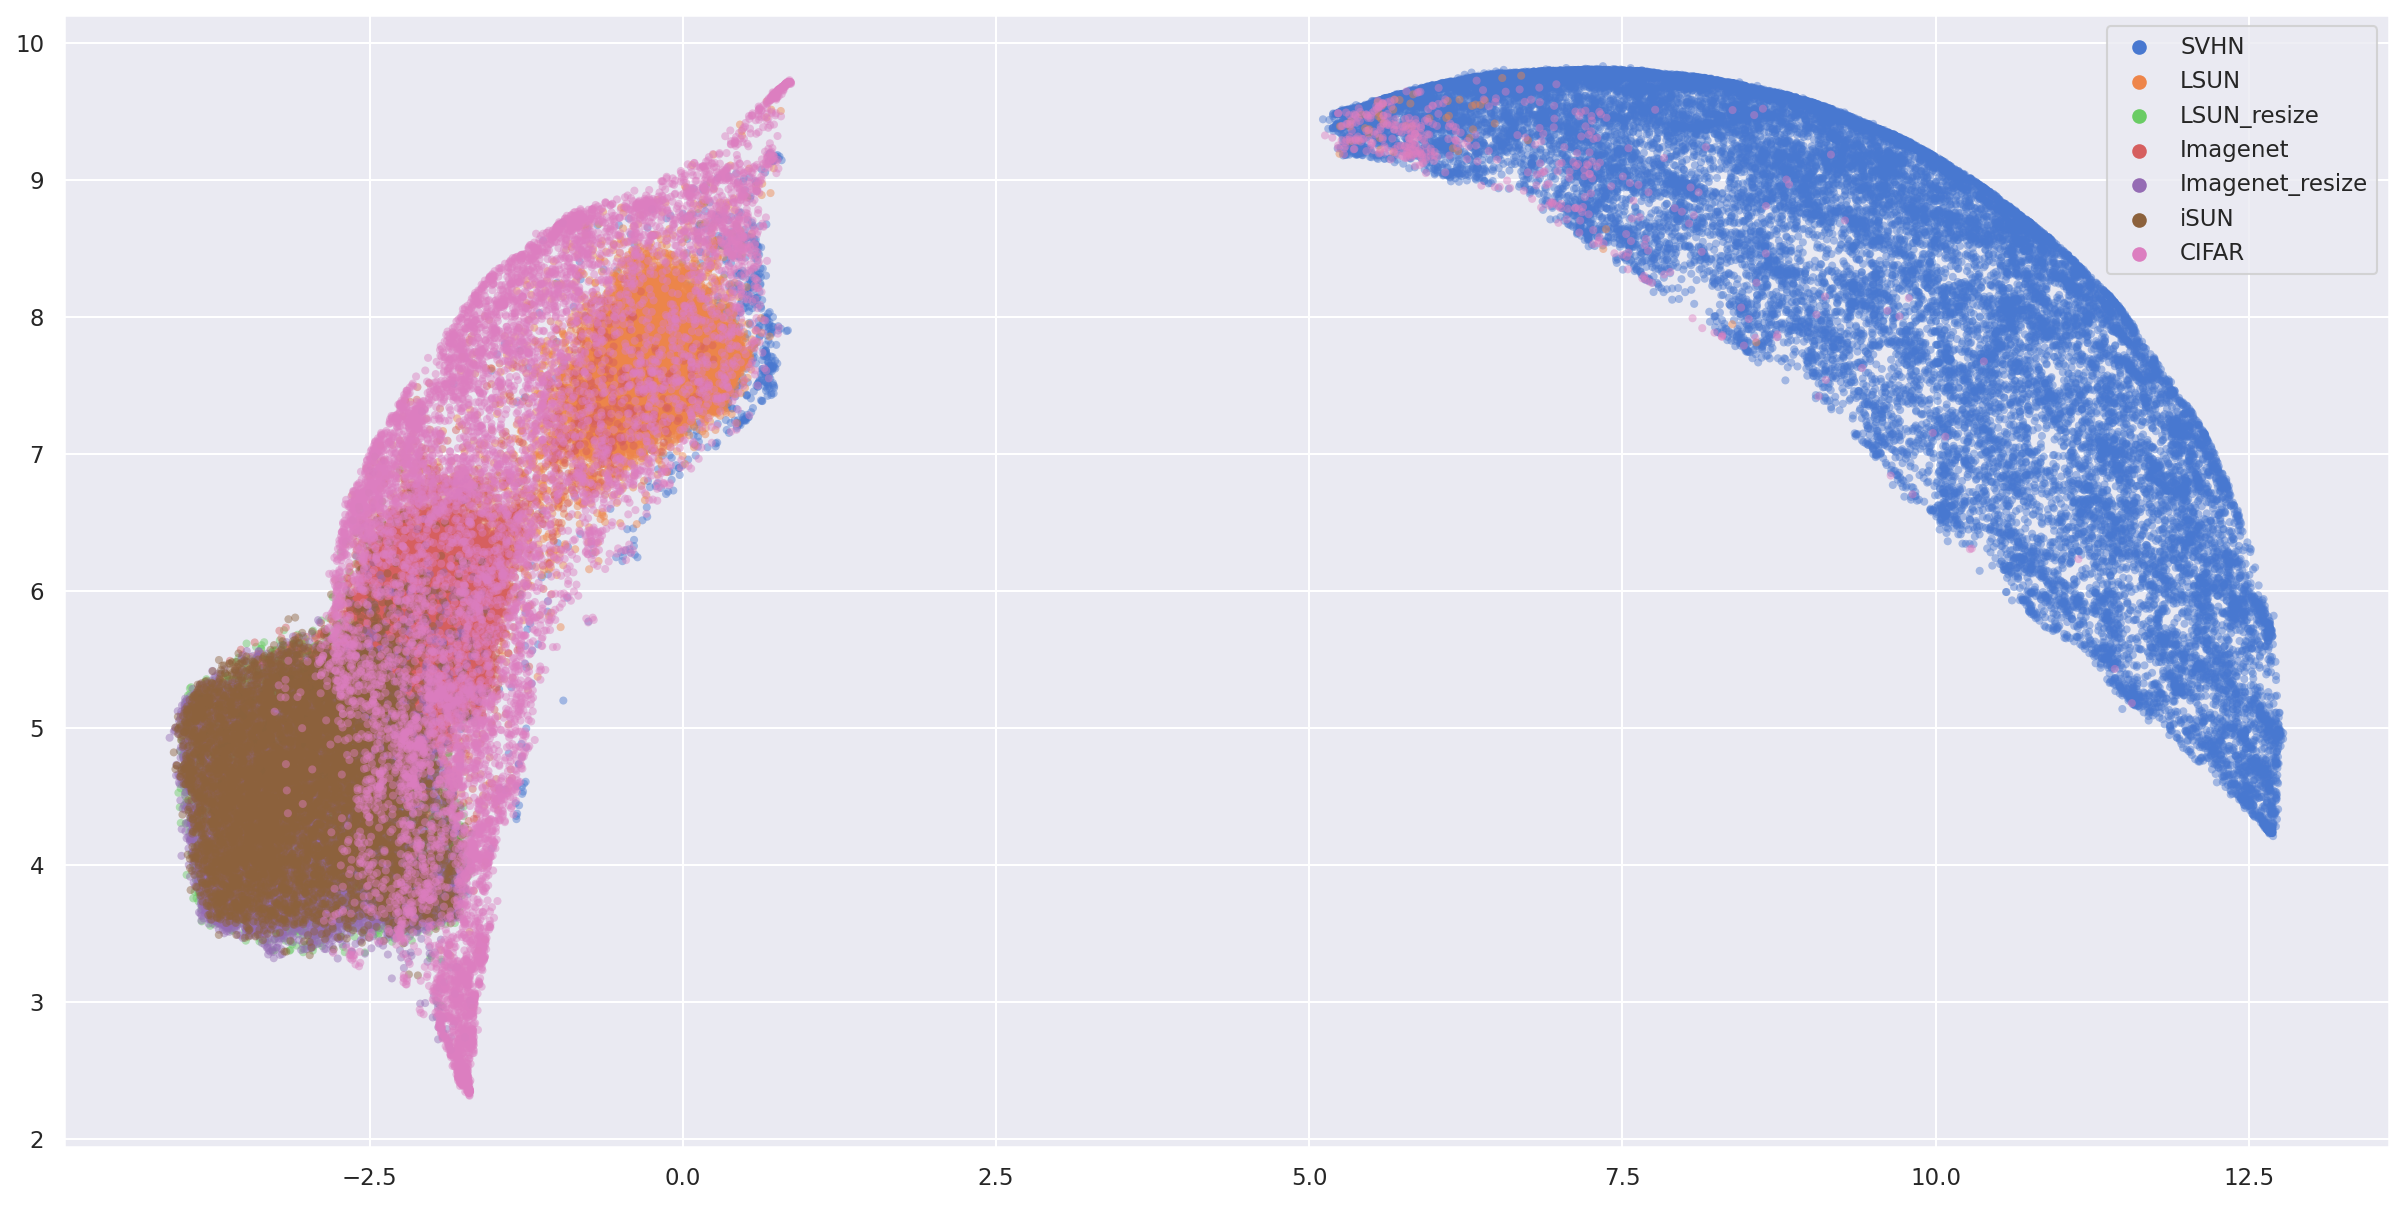

In [ ]:
plot_embedding(embedding, all_labels, captions)

## Train Data = L2-norm(Pixel Scores)

In [12]:
X_train, X_test =  inlier_scores[:6000], inlier_scores[6000:]

In [13]:
from ood_detection_helper import *

In [14]:
# def evaluate_model(train_score, inlier_score, outlier_scores, labels, **kwargs):
#     rows = 1 + int(np.ceil(len(outlier_scores)/2))
#     fig, axs = plt.subplots(rows, 1, figsize=(12,rows*4))
#     colors = sns.color_palette("bright") + sns.color_palette("dark")
    
#     sns.distplot(train_score, color=colors[0], label=labels[0], ax=axs[0], **kwargs)
#     sns.distplot(inlier_score, color=colors[1], label=labels[1], ax=axs[0], **kwargs)
    
#     offset = 2
#     for idx, _score in enumerate(outlier_scores):
#         idx += offset
#         sns.distplot(_score, color=colors[idx], label=labels[idx], ax=axs[0], **kwargs)    
    
#     offset = 0
#     for row in range(1, axs.shape[0]):
#         sns.distplot(inlier_score, color=colors[1], label=labels[1], ax=axs[row], **kwargs)
        
#         for idx, _score in enumerate(outlier_scores[offset: offset+2]):
#             idx += offset + 2
#             sns.distplot(_score, color=colors[idx], label=labels[idx], ax=axs[row], **kwargs)    
#         offset = 2 * row
        
#     for ax in axs: ax.legend()
#     plt.show()
    
#     return

## GMM

In [36]:
0.05*73000

3650.0

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   27.9s finished


Best: 4.671544 using {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
---------------------------------------------------------------------------
4.449794 (0.162398) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
4.587009 (0.157635) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
4.658164 (0.158472) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
4.671544 (0.161430) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
4.667200 (0.157530) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
4.668869 (0.147740) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
4.648583 (0.159925) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
4.634054 (0.168704) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
4.616114 (0.164788) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
4.599782 (0.165316) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
CPU times:

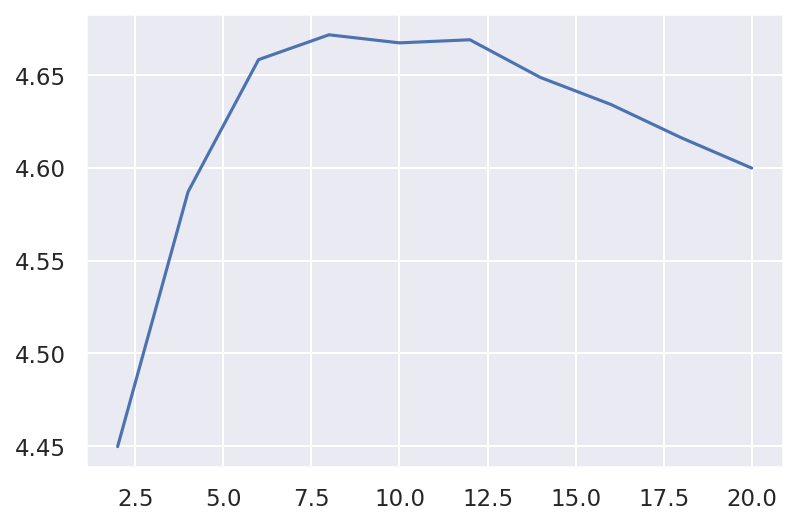

In [14]:
%%time
best_gmm_clf = train_gmm(X_train, verbose=True)

In [15]:
print("---Likelihoods---")
print("Training: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{}: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))

for name, ood in zip(LABELS[2:], outlier_scores):
    print("{}: {:.3f}".format(name, best_gmm_clf.score(ood)))

---Likelihoods---
Training: 4.786
SVHN: 4.696
LSUN: -986.129
LSUN_resize: -1060.329
Imagenet: -1001.090
Imagenet_resize: -1243.912
iSUN: -1202.148
Gaussian: -3229.111
Uniform: -1329.021
CIFAR: -11.557


In [16]:
%%time
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
ood_scores = [best_gmm_clf.score_samples(ood) for ood in outlier_scores]

CPU times: user 7.07 s, sys: 15.1 s, total: 22.1 s
Wall time: 543 ms


In [17]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18

## OOD Evaluation

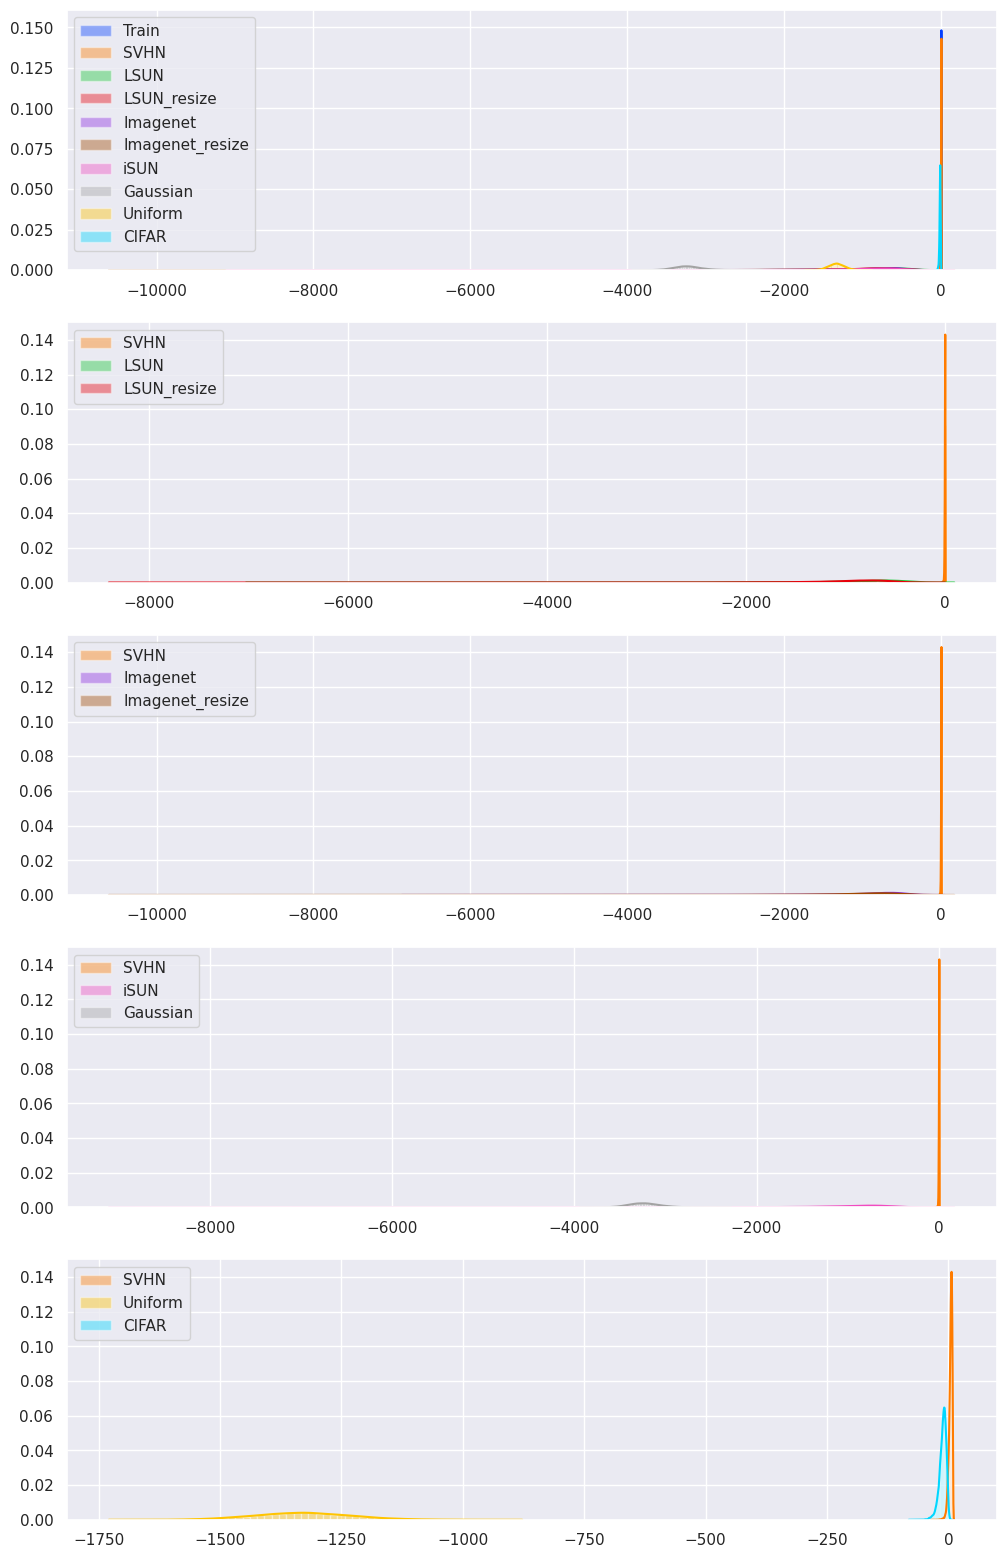

In [18]:
evaluate_model(train_score, test_score, ood_scores, labels=LABELS)

In [19]:
for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()

SVHN vs LSUN
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

SVHN vs LSUN_resize
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

SVHN vs Imagenet
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

SVHN vs Imagenet_resize
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

SVHN vs iSUN
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

SVHN vs Gaussian
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

SVHN vs Uniform
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

SVHN vs CIFAR
----------------
ROC-AUC: 0.9901
PR-AUC (In/Out): 0.9766 / 0.9955
FPR (95% TPR) Prec: 4.18%



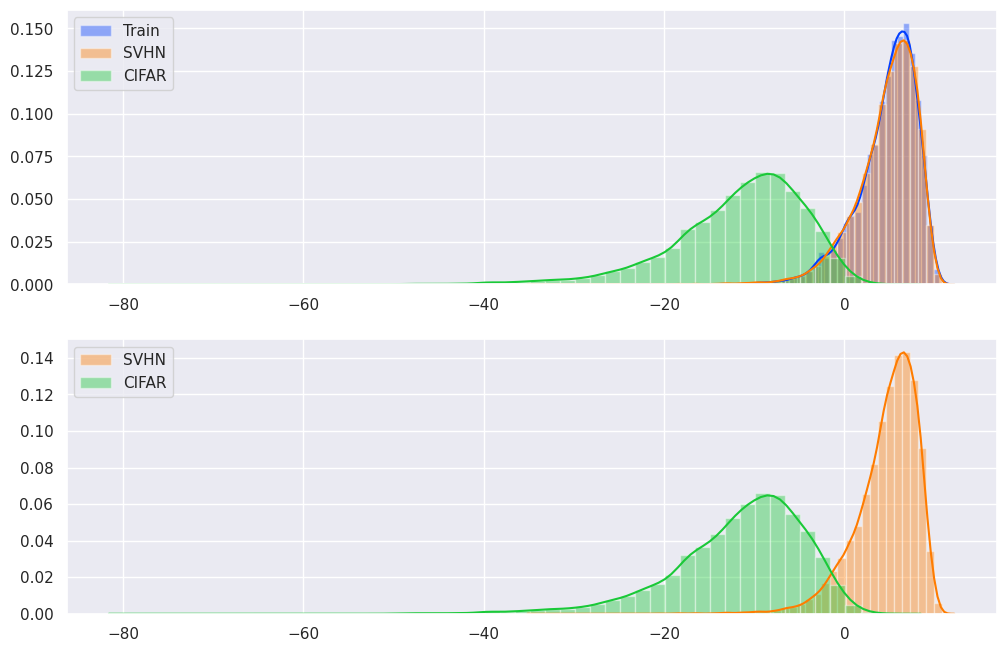

In [20]:
evaluate_model(train_score, test_score, ood_scores[-1:], labels=(*LABELS[:2], LABELS[-1]))

## All Images

In [65]:
all_images = np.concatenate(ood_scores)
all_images.shape

(78925,)

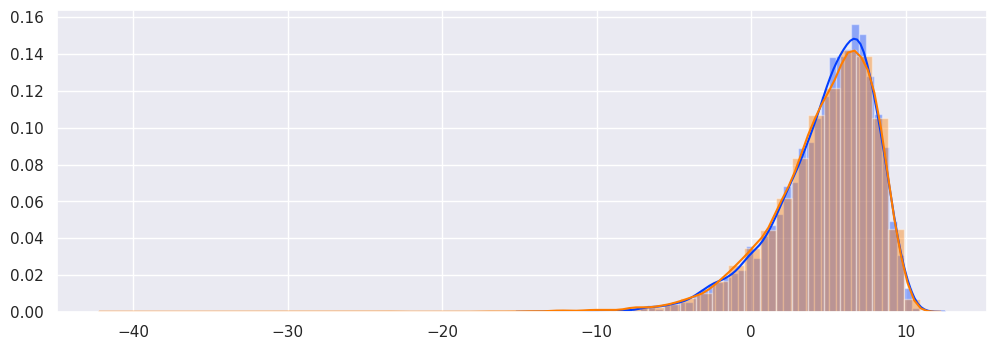

In [98]:
evaluate_model(train_score, test_score, [], labels=LABELS[:2])

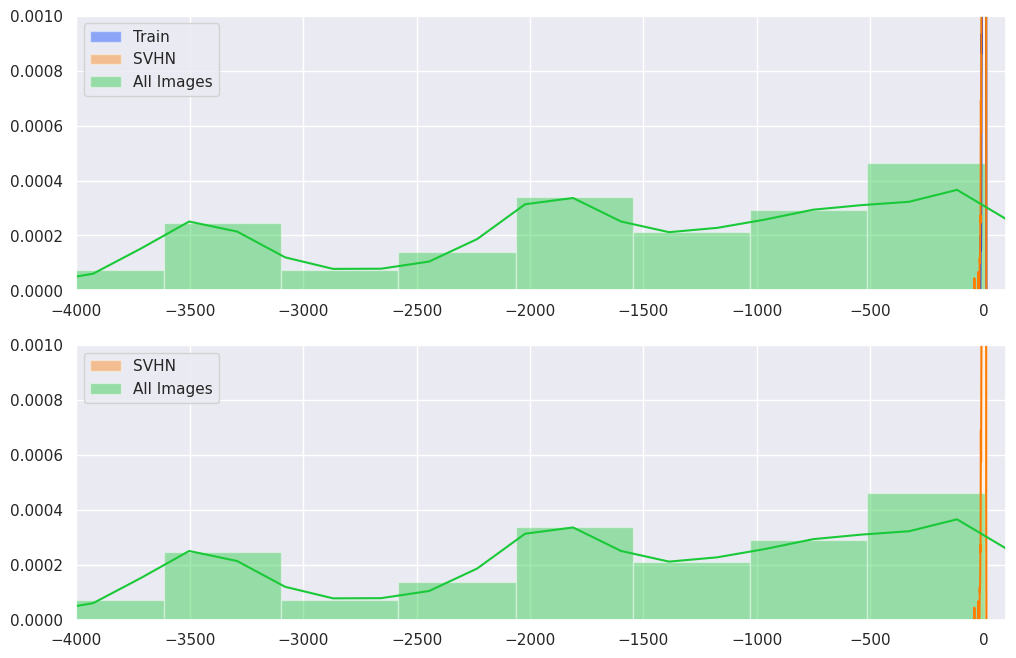

In [107]:
evaluate_model(train_score, test_score, [all_images], labels=(*LABELS[:2], "All Images"), ylim=0.001, xlim=-4000)

In [102]:
ood_metrics(-test_score, -all_images, names=(LABELS[1], "All Images"),plot=False, verbose=True)

SVHN vs All Images
----------------
ROC-AUC: 0.9988
PR-AUC (In/Out): 0.9997 / 0.9955
FPR (95% TPR) Prec: 0.0040


{'roc_auc': 0.9987871662971175,
 'fpr_tpr95': 0.00405,
 'fpr_tpr80': 0.0,
 'pr_auc_in': 0.9996923388540591,
 'pr_auc_out': 0.9955404356747337,
 'ap': 0.9996923408072709}

### Flow Models

In [210]:
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [212]:
# X_train = 
X_train.shape

(9000, 10)

In [222]:
# Density estimation with MADE.
n = X_train.shape[0]
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[256, 256], activation="elu")

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[10])

# Construct and fit model.
x_ = tfkl.Input(shape=(10,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adadelta(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob)

batch_size = 32
epochs = 1000
history = model.fit(
    x=X_train,
    y=np.zeros((n, 0), dtype=np.float32),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=n//batch_size,  # Usually `n // batch_size`.
    shuffle=True,
    verbose=True)

Epoch 1/1000
281/281 [==============================] - 1s 4ms/step - loss: 36103.8203
Epoch 2/1000
281/281 [==============================] - 1s 4ms/step - loss: 1998.8414
Epoch 3/1000
281/281 [==============================] - 1s 4ms/step - loss: 830.1052
Epoch 4/1000
281/281 [==============================] - 1s 4ms/step - loss: 602.1282
Epoch 5/1000
281/281 [==============================] - 1s 4ms/step - loss: 533.2385
Epoch 6/1000
281/281 [==============================] - 1s 4ms/step - loss: 507.7595
Epoch 7/1000
281/281 [==============================] - 1s 4ms/step - loss: 493.1132
Epoch 8/1000
281/281 [==============================] - 1s 4ms/step - loss: 481.1810
Epoch 9/1000
281/281 [==============================] - 1s 4ms/step - loss: 469.1931
Epoch 10/1000
281/281 [==============================] - 1s 4ms/step - loss: 460.3508
Epoch 11/1000
281/281 [==============================] - 1s 4ms/step - loss: 450.3121
Epoch 12/1000
281/281 [==============================] - 1s 

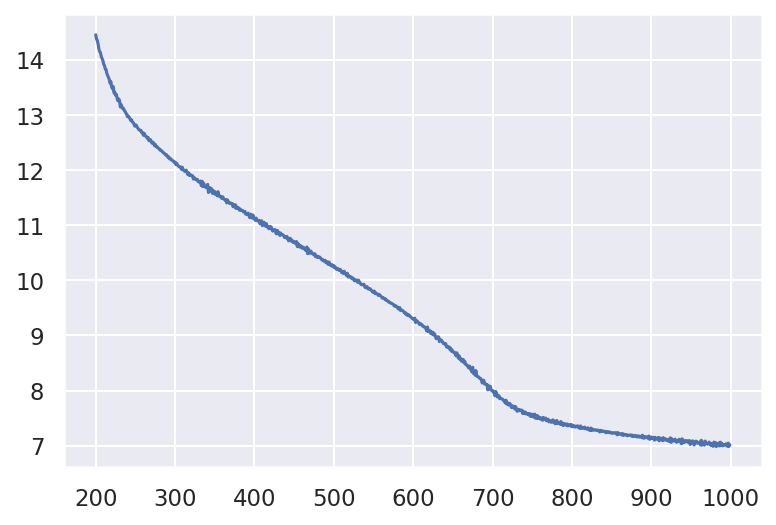

In [230]:
start_idx=200
plt.plot(range(start_idx, epochs), history.history["loss"][start_idx:])
# plt.yscale("log")

In [226]:
%%time
train_score = distribution.log_prob(X_train, dtype=np.float32).numpy()
test_score = distribution.log_prob(X_test, dtype=np.float32).numpy()
ood_scores = [distribution.log_prob(ood, dtype=np.float32).numpy() for ood in outlier_scores]

CPU times: user 142 ms, sys: 42.4 ms, total: 185 ms
Wall time: 177 ms


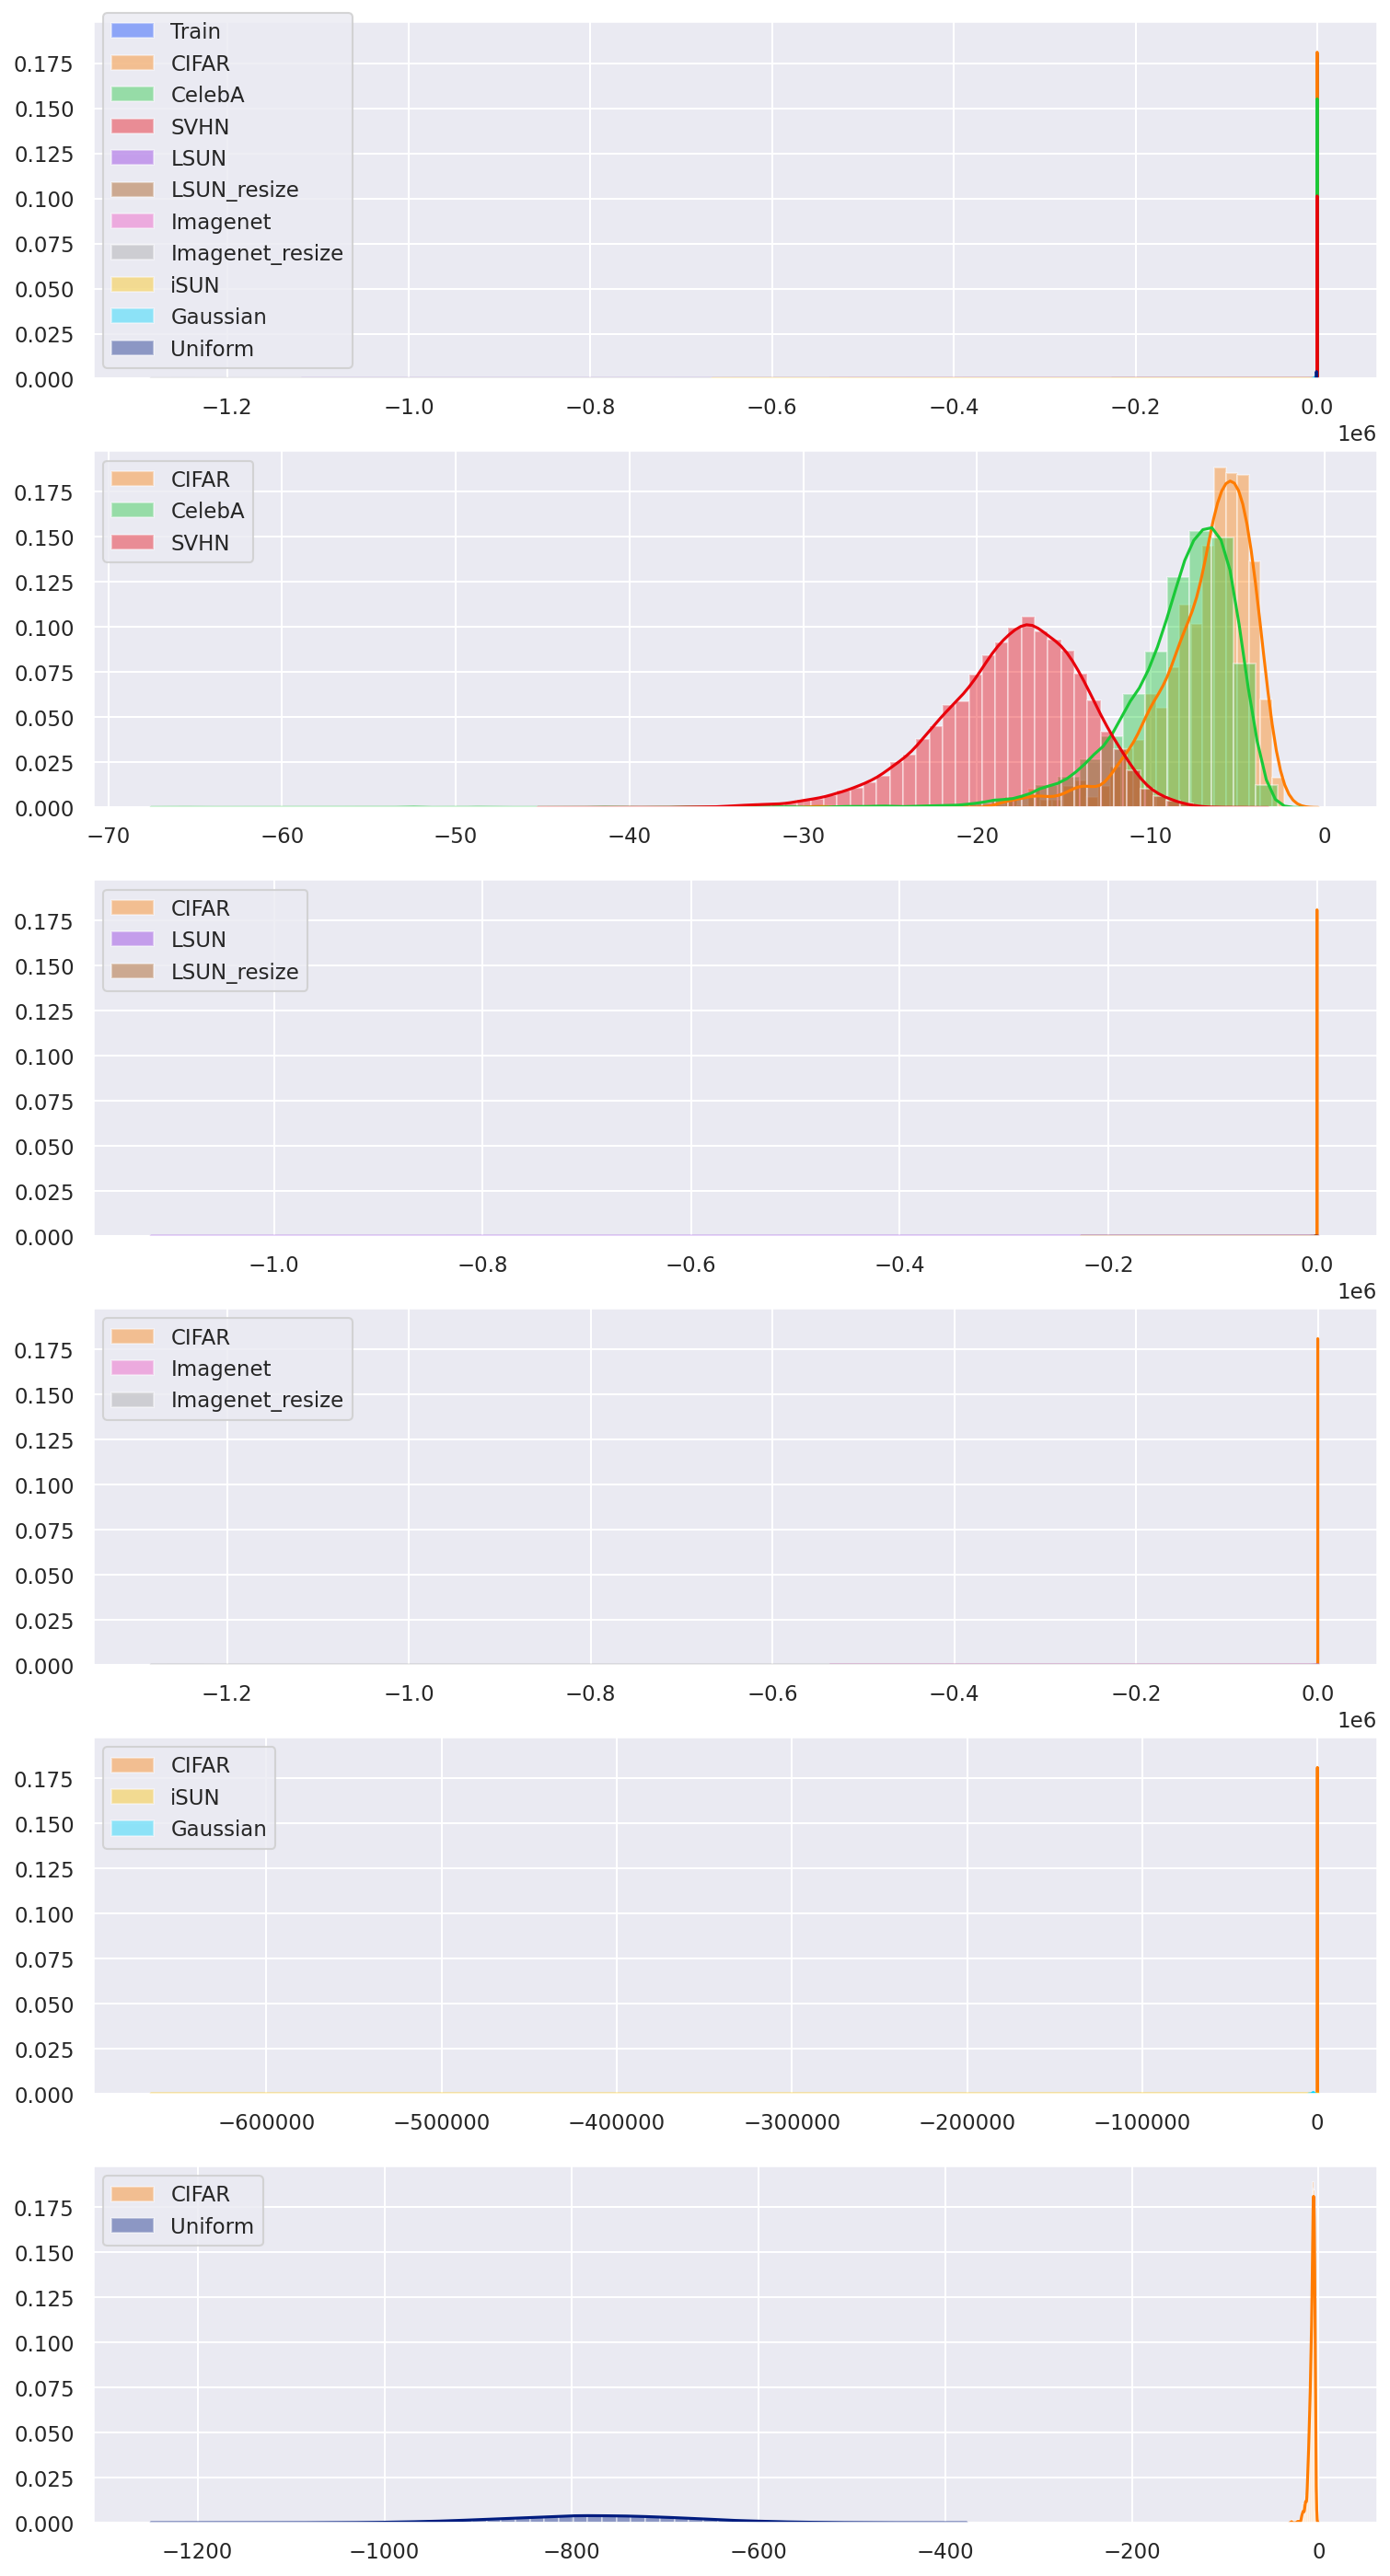

In [227]:
evaluate_model(train_score, test_score, ood_scores, labels=LABELS)

In [228]:
for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()

CIFAR vs CelebA
----------------
ROC-AUC: 0.6524
PR-AUC (In/Out): 0.9412 / 0.1895
FPR (95% TPR) Prec: 0.8150

CIFAR vs SVHN
----------------
ROC-AUC: 0.9818
PR-AUC (In/Out): 0.9973 / 0.9373
FPR (95% TPR) Prec: 0.0580

CIFAR vs LSUN
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs LSUN_resize
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Imagenet
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Imagenet_resize
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs iSUN
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 0.9999
FPR (95% TPR) Prec: 0.0000

CIFAR vs Gaussian
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Uniform
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.000